## 💡 1. Introduction 

In this document we will process the data [retrieved](https://github.com/i442124/SuperScope/tree/main/notebooks/data_retrieval_document.ipynb) and prepare it so it can be used as input data for modeling. We start off with a quick inspection of the raw data we've collected. Then we use our knowledge from the [EDA's](https://github.com/i442124/SuperScope/tree/main/notebooks) to determine what we are going to do with the missing/duplicate data. After that we start with some preprocessing to improve the performance of our application.

## ⚙️ 2. Settings

In [1]:
############# FILES ##############

GAME_DETAILS_PATH = '../data/video-games/raw-game-details.json'
GAME_REVIEWS_PATH = '../data/video-games/raw-game-reviews.json'
GAME_IMAGES_PATH = '../data/box-art/raw-images.json'

GAME_DETAILS_OUT_PATH = '../data/video-games'
GAME_REVIEWS_OUT_PATH = '../data/video-games'
GAME_IMAGES_OUT_PATH = '../data/box-art'


####### FEATURE SELECTION ########

GAME_DETAILS_SELECTION = ['title', 'platform', 'publisher', 'genres']
GAME_REVIEWS_SELECTION = ['title', 'platform', 'meta_score', 'review_critic']


######### PREPROCESSING ##########

## The size (in pixels) of the images
## used while extracting image features
PREPROCESS_IMAGE_SIZE = 256

## Amount of of keypoints to 
## extract from the target images
PREPROCESS_IMAGE_FEATURE_COUNT = 500

## Whether or not you intend to use 
## feature extraction (DON'T PUT ON FALSE!)
PREPROCESS_IMAGE_FEATURE_EXTRACTION = True

## Size in pixels that will be used
## to measure the structural similatry (SSIM)
PREPROCESS_IMAGE_STRUCUTRE_SIZE = 16

## Whether or not to store the color 
## information in the stuctured image
PREPROCESS_IMAGE_STRUCUTRE_COLOR = True

## Whether or not you intend to use SSIM
PREPROCESS_IMAGE_STRUCUTRE_EXTRACTION = True

## Calculate and store the color histogram of images
PREPROCESS_IMAGE_COLOR_HISTOGRAM = True

## 📚 3. Preperations

### 3.1 Importing libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 3.2 Loading the data
Let's start off by loading in the data we've collected from our domain sources and strip all the features we don't want/need in the dataset. This will significantly reduce the amount of storage/memory required for these datasets.

In [3]:
# Load the raw data from the details path
games = pd.read_json(GAME_DETAILS_PATH)
# Apply the feature selection
games = games[GAME_DETAILS_SELECTION]
# Show sample of the data
games.sample(n=5, random_state=42)

,title,platform,publisher,genres
3571,Red Orchestra: Ostfront 41-45,PC,Bold Games,"[Action, Shooter, Shooter, First-Person, Histo..."
16592,Dreamcast Collection,Xbox 360,Sega,"[Miscellaneous, Compilation, Compilation]"
16533,Planar Conquest,PC,Wastelands Interactive,"[Strategy, Turn-Based, 4X]"
5245,Conker: Live & Reloaded,Xbox,Microsoft Game Studios,"[Action, Shooter, Third-Person, Fantasy]"
16339,Port Royale 3: Pirates and Merchants,PC,Kalypso,"[Strategy, Real-Time, General, General]"


In [4]:
# Load the raw data from the reviews path
ratings = pd.read_json(GAME_REVIEWS_PATH)
# Apply the feature selection
ratings = ratings[GAME_REVIEWS_SELECTION]
# Show sample of the data
ratings.sample(n=5, random_state=42)

,title,platform,meta_score,review_critic
88541,Terraria,PC,85.0,GameTrailers
108679,Virtual Pool 3,PC,85.0,GamerWeb PC
393766,Tecmo Classic Arcade,Xbox,59.0,Xbox Evolved
173811,Far Cry 5,PC,80.0,Game World Navigator Magazine
372616,Legends of Wrestling II,PlayStation 2,50.0,Gaming Age


### 3.3 Loading the images
The images are provided by a different domain then the details/reviews, however we've used the same indexing file to look the for both the details and box-art of all games. This means we can simply merge these two datasets by their order of appearance in the datasets, and they should all align up correctly.

In [5]:
# Load the raw data from the image path
images = pd.read_json(GAME_IMAGES_PATH)
# Merge the dataset by using the indices from the game details
images = pd.merge(games.reset_index(), images)
# Restrict the image dataset to only the title, platform and an image
images = images[['title', 'platform', 'image']]

The images themselves are stored in a base64 encoded format. This helps us to avoid the potential loss of information due to hidden characters used in the binary data. We can easily decode them back to the original format load them into a readable image. Let's quickly validate if everything is still working correctly.

In [6]:
import cv2
import base64

In [7]:
def load_image(data):
    # Decode the base64 string
    img = base64.b64decode(data)
    # put the image into a byte sequence
    array = np.frombuffer(img, dtype=np.uint8)
    # decode the image from the provided bytes
    decoded_image = cv2.imdecode(array, cv2.IMREAD_COLOR)
    # reverse byte order from BGR to RGB (for use in Matplotlib)
    return cv2.cvtColor(decoded_image, cv2.COLOR_BGR2RGB)

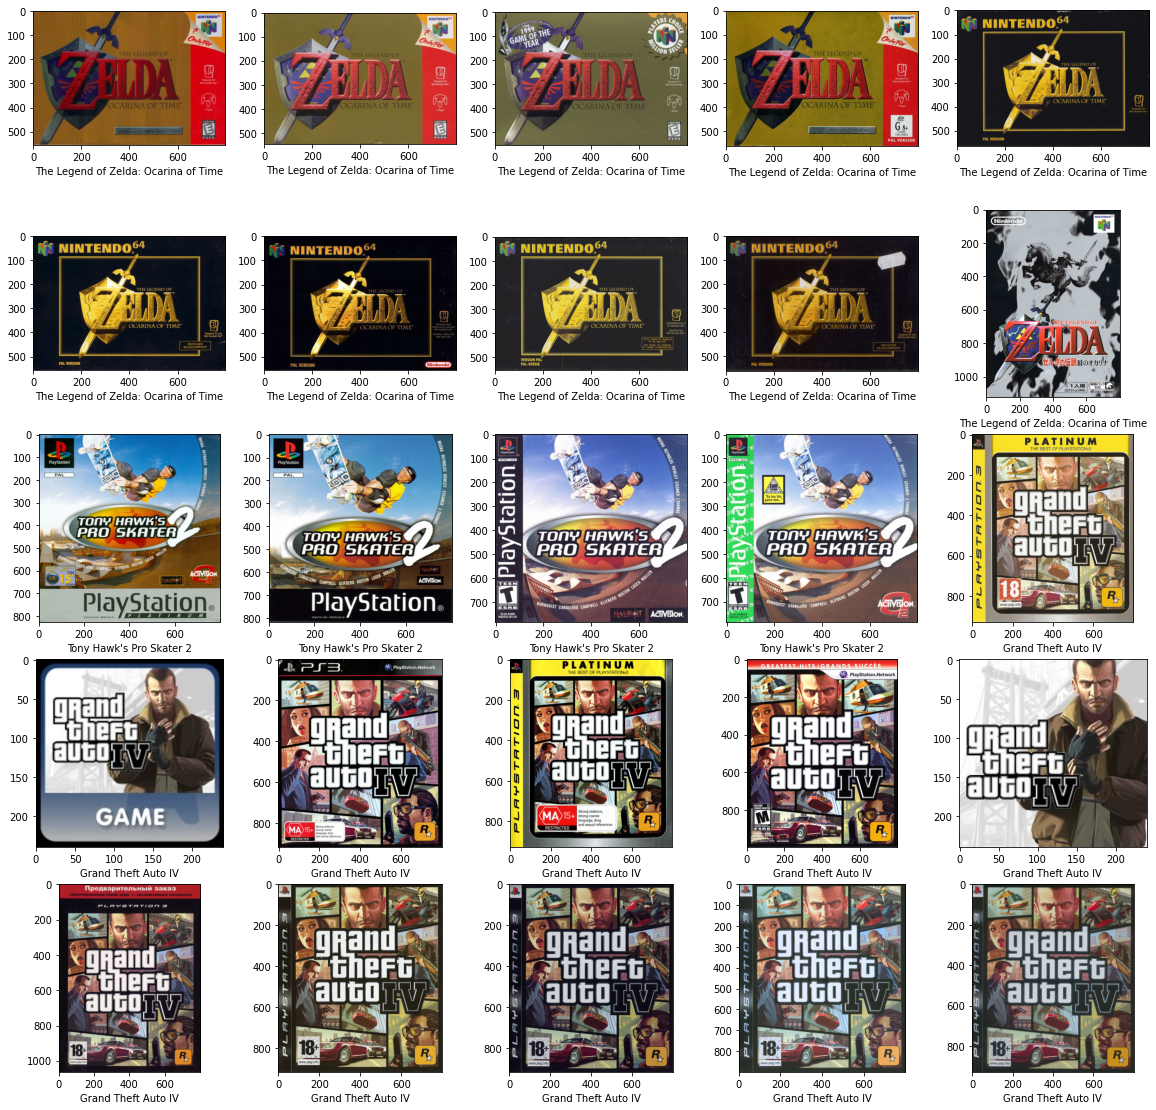

In [8]:
## Display images
## on a 5x5 grid
ncols = 5
nrows = 5

## Quickly validate if the
## images have been correctly
## extracted and can be decoded
plt.figure(figsize=(20, 20))
for i in range(nrows * ncols):
    plt.subplot(nrows, ncols, i + 1)
    plt.xlabel(images['title'].iloc[i])
    plt.imshow(load_image(images['image'].iloc[i]))
    
# Show images
plt.show()

## 🧹 4. Cleaning

### 4.1 Solving null values

In [9]:
games.isnull().sum()

title         0
platform      0
publisher    12
genres        0
dtype: int64

In [10]:
images.isnull().sum()

title       0
platform    0
image       0
dtype: int64

In [11]:
ratings = ratings[ratings['review_critic'].notna()]
ratings = ratings[ratings['meta_score'].notna()]
ratings.isnull().sum()

title            0
platform         0
meta_score       0
review_critic    0
dtype: int64

### 4.2 Solving duplicate values

In [12]:
games['genres'] = games['genres'].apply(lambda x: list(set(x)))
games = games.drop_duplicates(subset=['title', 'platform'])
games

,title,platform,publisher,genres
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,Nintendo,"[Action Adventure, Fantasy]"
1,Tony Hawk's Pro Skater 2,PlayStation,Activision,"[Sports, Alternative, Skateboarding]"
2,Grand Theft Auto IV,PlayStation 3,Rockstar Games,"[Modern, Action Adventure, Open-World]"
3,SoulCalibur,Dreamcast,Namco,"[3D, Action, Fighting]"
4,Grand Theft Auto IV,Xbox 360,Rockstar Games,"[Modern, Action Adventure, Open-World]"
...,...,...,...,...
18291,Stalin vs. Martians,PC,Mezmer Games,"[Strategy, Military, General, Real-Time]"
18292,NBA Unrivaled,Xbox 360,Tecmo,"[Sports, Basketball, Traditional, Arcade]"
18293,Cruis'n,Wii,Midway,"[Driving, Racing, Automobile, Arcade]"
18294,NBA Unrivaled,PlayStation 3,Tecmo,"[Sports, Basketball, Traditional, Arcade]"


In [13]:
ratings = ratings.drop_duplicates()
ratings

,title,platform,meta_score,review_critic
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Hot Games
1,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,GameShark
2,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Cincinnati Enquirer
3,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Nintendophiles
4,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Electronic Gaming Monthly
...,...,...,...,...
426390,Family Party: 30 Great Games Obstacle Arcade,Wii U,10.0,Nintendo Life
426391,Family Party: 30 Great Games Obstacle Arcade,Wii U,10.0,NintendoWorldReport
426392,Family Party: 30 Great Games Obstacle Arcade,Wii U,10.0,Gamereactor Denmark
426393,Family Party: 30 Great Games Obstacle Arcade,Wii U,10.0,Eurogamer Sweden


## ♻️ 5. Preprocessing

### 5.1 Extracting image features
This part is a bit more difficult to explain than the other parts. Images consist of a lot of information like a [color histograms](https://www.researchgate.net/profile/Mark-Stamp/publication/327660647/figure/fig1/AS:689229801730049@1541336598739/RGB-channels-of-color-histogram.jpg), [image-structures](https://towardsdatascience.com/how-pictures-structural-similarity-can-boost-your-computer-vision-projects-3dbb721a0fa), [keypoints and descriptors](https://stackoverflow.com/a/29137285) that we can use to determine the similarity between images. These calculations will always yield the same results, so we can store these values in the dataset as well. Once we need these features in our algorithms, we can easily load them from memory in a moments notice without having to calculate them on the spot.

I've created yet another CLI so we can easily extract the features we want according to the settings provided above. Remember that you can always use the help command to see all the parameters we can pass to the python script.

In [14]:
%run -i ..\scripts\image_extractor\__main__ --help

usage: __main__.py [-h] [-es] [-eh] [-ef] [-c] [-s SIZE] [-k KEYPOINTS] [-W WIDTH] [-H HEIGHT] [-o [OUTPUT]] file

Image Feature Extractor

positional arguments:
  file                  File with list of MobyGames box-art images.

optional arguments:
  -h, --help            show this help message and exit
  -es, --extract_structure
                        Extract the structural analysis image.
  -eh, --extract_histogram
                        Extract the color histogram of the images.
  -ef, --extract_features
                        Extract the keypoints and descriptors of images.
  -c, --color           Retain color information in similarity image.
  -s SIZE, --size SIZE  The size of the structual similarty image.
  -k KEYPOINTS, --keypoints KEYPOINTS
                        The amount of keypoints to extract.
  -W WIDTH, --width WIDTH
                        Width in pixels when extracting features.
  -H HEIGHT, --height HEIGHT
                        Height in pixels when extracti

Let's assemble the arguments from the settings into a single string that we can pass to the tool.

In [15]:
## We build our
## arguments as we go
args = ''

# Do we want to extract the image features
if PREPROCESS_IMAGE_FEATURE_EXTRACTION:
    # Yes!, let's pass all the parameters
    args += f'--extract_features '
    args += f'--height {PREPROCESS_IMAGE_SIZE} '
    args += f'--keypoints {PREPROCESS_IMAGE_FEATURE_COUNT} '
    
# Do we want to extract the image strucutre
if PREPROCESS_IMAGE_STRUCUTRE_EXTRACTION:
    # Yes!, let's pass all the parameters
    args += f'--extract_structure '
    args += f'--size {PREPROCESS_IMAGE_STRUCUTRE_SIZE} '
    if PREPROCESS_IMAGE_STRUCUTRE_COLOR: args += f'--color '
        
# Do we want to extract the color histogram
if PREPROCESS_IMAGE_COLOR_HISTOGRAM:
    # Yes!, let's pass all the parameters
    args += f'--extract_histogram ' 

For the output, we want to use some kind of naming convention to know what we've extracted. You can make it as detailed as you want, but I'll just stick to the image size and feature count for the time being.

In [16]:
GAME_IMAGES_OUT_PATH = f'{GAME_IMAGES_OUT_PATH}/images-{PREPROCESS_IMAGE_SIZE}x-K{PREPROCESS_IMAGE_FEATURE_COUNT}.pkl'

Now that everything is prepared we can run the script!

In [17]:
%run -i ..\scripts\image_extractor\__main__ $GAME_IMAGES_PATH $args --output $GAME_IMAGES_OUT_PATH

Processing images: 5260 of 5260
Done!


Let's combine the original image data with the output from the image feature extractor and confirm that everything is still in place.

In [18]:
images = pd.merge(images, pd.read_pickle(GAME_IMAGES_OUT_PATH).drop(columns='index'))
images.head(10)

,title,platform,image,histogram,structure,keypoints,descriptors
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEBLAEsAAD//gAPTW9ieUdhbWVzLm...,"[[[0.05390031, 0.021545487, 0.06083087, 0.1255...","[[[26, 85, 133], [24, 84, 130], [27, 90, 141],...","[<KeyPoint 00000134DF557C60>, <KeyPoint 000001...","[[0.0, 21.0, 108.0, 14.0, 0.0, 0.0, 0.0, 0.0, ..."
1,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEAlgCWAAD//gAPTW9ieUdhbWVzLm...,"[[[0.007238588, 0.0146701345, 0.0045215096, 0....","[[[53, 107, 123], [54, 108, 124], [50, 104, 12...","[<KeyPoint 0000013520793060>, <KeyPoint 000001...","[[69.0, 6.0, 0.0, 0.0, 0.0, 45.0, 107.0, 29.0,..."
2,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEAlgCWAAD//gAPTW9ieUdhbWVzLm...,"[[[0.043081634, 0.00883361, 0.0016102262, 2.58...","[[[71, 108, 113], [71, 112, 114], [74, 115, 11...","[<KeyPoint 00000134F51BD960>, <KeyPoint 000001...","[[12.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 63..."
3,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEAAQABAAD//gAPTW9ieUdhbWVzLm...,"[[[0.10731656, 0.017915377, 0.015442496, 0.027...","[[[8, 109, 134], [7, 114, 142], [8, 114, 145],...","[<KeyPoint 00000134EDE813C0>, <KeyPoint 000001...","[[85.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 199..."
4,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEBLAEsAAD//gAPTW9ieUdhbWVzLm...,"[[[0.99692065, 0.020727146, 3.3941833e-05, 7.5...","[[[42, 38, 36], [28, 23, 24], [29, 24, 25], [2...","[<KeyPoint 00000134F0420960>, <KeyPoint 000001...","[[4.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0,..."
5,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEAyADIAAD//gAPTW9ieUdhbWVzLm...,"[[[0.99303395, 0.035098244, 9.964298e-05, 0.0,...","[[[24, 15, 3], [24, 13, 4], [32, 21, 13], [25,...","[<KeyPoint 00000134F17A1300>, <KeyPoint 000001...","[[3.0, 43.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19..."
6,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEBLAEsAAD//gAPTW9ieUdhbWVzLm...,"[[[0.9981629, 0.016575342, 0.0008810003, 0.000...","[[[12, 4, 5], [11, 3, 4], [9, 1, 2], [11, 3, 4...","[<KeyPoint 00000134F62F1750>, <KeyPoint 000001...","[[0.0, 1.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, 24.0..."
7,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEBLAEsAAD//gAPTW9ieUdhbWVzLm...,"[[[0.0013016931, 0.004278609, 7.5460475e-06, 0...","[[[34, 34, 35], [39, 35, 32], [38, 36, 36], [3...","[<KeyPoint 00000134EB5FED50>, <KeyPoint 000001...","[[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 12.0..."
8,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQEAAQABAAD//gAPTW9ieUdhbWVzLm...,"[[[0.9897527, 0.089888714, 0.00030712227, 0.0,...","[[[24, 21, 26], [30, 22, 24], [24, 20, 31], [1...","[<KeyPoint 00000134ECB1D330>, <KeyPoint 000001...","[[5.0, 5.0, 2.0, 0.0, 1.0, 1.0, 1.0, 7.0, 81.0..."
9,The Legend of Zelda: Ocarina of Time,Nintendo 64,/9j/4AAQSkZJRgABAQECWAJYAAD//gAPTW9ieUdhbWVzLm...,"[[[0.6505498, 0.010189542, 0.0003599992, 1.565...","[[[44, 44, 48], [112, 110, 108], [56, 52, 53],...","[<KeyPoint 00000134F3C11570>, <KeyPoint 000001...","[[94.0, 30.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 20..."


## 💾 6. Storage
Now that all the preprocessing is done, it's time to store our data. The first location that I'm going to save these variables to is the [magic storage](https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html), which is a lightweight persistence layer to share variables, aliases and macros between different notebooks. It's also nice to have the data available in a physical location as well, so I'm going to store it in the data folder of this project as well.

### 6.1 Magic Storage

In [19]:
%store games
%store images
%store ratings

Stored 'games' (DataFrame)
Stored 'images' (DataFrame)
Stored 'ratings' (DataFrame)


### 6.2 File Storage

In [20]:
GAME_DETAILS_OUT_PATH = f'{GAME_DETAILS_OUT_PATH}/game-details.csv'
GAME_REVIEWS_OUT_PATH = f'{GAME_REVIEWS_OUT_PATH}/game-reviews.csv'

In [21]:
# Export game details to the correct out path
games.to_csv(GAME_DETAILS_OUT_PATH, index=False)

# Export game reviews to the correct out path
ratings.to_csv(GAME_REVIEWS_OUT_PATH, index=False)

# Export game images to the correct out path
# We use pickle format to save the lists properly
images.to_pickle(GAME_IMAGES_OUT_PATH)